In [84]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler
#import torchvision
#import lightning


In [85]:
# data_dir = os.path.join(os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py/data_batch_1")
data_dir = os.path.join(
    os.path.dirname(os.getcwd()),
    "Data/CIFAR10/cifar-10-batches-py",
    "train_data.pkl",
)
data_dir_val = os.path.join(
    os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py/test_batch"
)
# batch_size = 2
num_in_channels = 3
dim_z = 16
kern_size = 4
lr = 2e-4
num_epochs = 3

num_disc_feat = 32
disc_stride = 1
disc_padding_size = 0

num_gen_feat = 32
gen_stride = 3
gen_padding_size = 1

mean = 0
std = 0.02  # from the DCGAN paper

if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"


In [86]:
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [59]:
def process_data(folder_dir):
    file_paths = os.listdir(folder_dir)
    combined_img_data = []
    combined_label_data = []
    for file in file_paths:
        if "data_batch" in file:
            combined_img_data.append(
                unpickle(os.path.join(folder_dir, file))[b"data"]
            )
            combined_label_data.append(
                unpickle(os.path.join(folder_dir, file))[b"labels"]
            )
    combined_img_data = np.concatenate(combined_img_data)
    combined_label_data = np.concatenate(combined_label_data)
    # with open(os.path.join(folder_dir, "train_img_data.pkl"), 'wb') as f:
    #     pickle.dump(combined_img_data, f)
    # with open(os.path.join(folder_dir, "train_label_data.pkl"), 'wb') as f:
    #     pickle.dump(combined_label_data, f)

    train_data = {}
    train_data[b"data"] = combined_img_data
    train_data[b"labels"] = combined_label_data
    with open(os.path.join(folder_dir, "train_data.pkl"), "wb") as f:
        pickle.dump(train_data, f)

In [ ]:
process_data(
    os.path.join(
        os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py"
    )
)

In [8]:
(unpickle(data_dir).keys())


dict_keys([b'data', b'labels'])

In [78]:
class TrainDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.train_data = unpickle(data_dir)

    def __getitem__(self, idx):
        img = torch.tensor(
            self.train_data[b"data"][idx].reshape(3, 32, 32),
            dtype=torch.float32,
        )
        label = torch.tensor(
            self.train_data[b"labels"][idx], dtype=torch.float32
        )
        # return img, label
        return {"img": img, "label": label}

    def __len__(self):
        return len(self.train_data[b"labels"])

In [87]:
class ValDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.val_data = unpickle(data_dir)

    def __getitem__(self, idx):
        img = torch.tensor(
            self.val_data[b"data"][idx].reshape(3, 32, 32), dtype=torch.float32
        )
        label = torch.tensor(self.val_data[b"labels"][idx], dtype=torch.float32)
        # return img, label
        return {"img": img, "label": label}

    def __len__(self):
        return len(self.val_data[b"labels"])

In [88]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.ngpu = ngpu
        self.net = nn.Sequential(
            # nn.BatchNorm2d(num_in_channels),
            nn.Conv2d(
                num_in_channels,
                num_disc_feat,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat,
                num_disc_feat * 2,
                kern_size,
                4,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_feat * 2),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat * 2,
                num_disc_feat * 4,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_feat * 4),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat * 4,
                1,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(1),
            nn.LeakyReLU()
        )

        for layer in self.net.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean, std)

    def forward(self, x):
        z = self.net(x)
        return z

In [147]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.ngpu = ngpu
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                dim_z, num_gen_feat * 4, kern_size, 1, 0, bias=False
            ),
            # ConvTranspose2d are the fractionally strided convolutions used for upscaling mentioned in the paper
            nn.BatchNorm2d(num_gen_feat * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat * 4, num_gen_feat * 2, kern_size, 2, 1, bias=False
            ),
            nn.BatchNorm2d(num_gen_feat * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat * 2, num_gen_feat, kern_size, 2, 1, bias=False
            ),
            nn.BatchNorm2d(num_gen_feat),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat, num_in_channels, kern_size, 2, 1, bias=False
            ),
            nn.Sigmoid(),
        )

        for layer in self.net.modules():
            if isinstance(layer, nn.ConvTranspose2d):
                nn.init.normal_(layer.weight, mean, std)

    def forward(self, x):
        z = self.net(x)
        return z

In [148]:
train_dataset = TrainDataset(data_dir)
train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0, shuffle=True)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=train_sampler,
)

val_dataset = ValDataset(data_dir_val)
val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0, shuffle=True)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=val_sampler,
)

In [149]:
def train(num_epochs, data_dir, data_dir_val, device, train=True, **kwargs):

    loss_fn = torch.nn.BCEWithLogitsLoss()

    train_dataset = TrainDataset(data_dir)
    train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0)
    batch_size = kwargs.get("batch_size", 100)
    gen_lr = kwargs.get("gen_lr", 2e-4)
    disc_lr = kwargs.get("disc_lr", 2e-4)
    k = kwargs.get("k", 1)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        sampler=train_sampler,
    )
    if train == False:
        val_dataset = ValDataset(data_dir_val)
        val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0)
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
            sampler=val_sampler,
        )
    
    optimG = torch.optim.Adam(gen.parameters(), lr=gen_lr, betas=(0.5, 0.0))
    optimD = torch.optim.Adam(disc.parameters(), lr=disc_lr, betas=(0.5, 0.0))
    # optimD = torch.optim.SGD(disc.parameters(), lr=2e-4)

    # noise = torch.randn(28, dim_z, 1, 1, device=device)

    # real_label = 1
    # fake_label = 0
    loss_d, loss_g, imgs = [], [], []
    
    if train:
        for i in range(num_epochs):
            print(f"Epoch no. :  {i+1}")
            nan_flag = False
            if nan_flag==False:
                for j, mini_batch in enumerate(train_loader):
                    optimG.zero_grad()

                    for _ in range(k):
                        optimD.zero_grad()

                        # train disc first
                        x_real = torch.nn.functional.normalize(mini_batch["img"].to(device))
                        x_real = x_real.view(batch_size, num_in_channels, 32, 32)
                        labels = torch.full(
                            (batch_size,), 1.0, dtype=torch.float32, device=device
                        )
                        # out_disc_r = disc(x_real).flatten().sigmoid()
                        out_disc_r = disc(x_real).flatten()

                        # print(out_disc_r)
                        loss_disc_r = loss_fn(out_disc_r, labels)
                        loss_disc_r.backward()

                        x_fake = gen(torch.randn(batch_size, dim_z, 1, 1, device=device))
                        labels = torch.full(
                            (batch_size,), 0.0, dtype=torch.float32, device=device
                        )
                        # out_disc_f = disc(x_fake).flatten().sigmoid()
                        out_disc_f = disc(x_fake).flatten()
                        loss_disc_f = loss_fn(out_disc_f, labels)
                        if torch.isnan(loss_disc_f) or torch.isnan(loss_disc_r):
                            break
                        loss_disc_f.backward()

                        loss_disc = (
                            loss_disc_f.mean().item() + loss_disc_r.mean().item()
                        ) / 2.0

                        optimD.step()

                    # train gen
                    x_gen = gen(torch.randn(batch_size, dim_z, 1, 1, device=device))
                    x_gen = torch.nn.functional.normalize(x_gen)
                    # out = disc(x_gen).flatten().sigmoid()
                    out = disc(x_gen).flatten()
                    labels = torch.full(
                        (batch_size,), 1.0, dtype=torch.float32, device=device
                    )
                    loss_gen = loss_fn(out, labels)
                    loss_gen.backward()
                    
                    loss_d.append(loss_disc)
                    loss_g.append(loss_gen.item())
                    if loss_disc == np.NaN or loss_gen.item() == np.NaN:
                        nan_flag = True
                        break

                    if j % 200 == 0:
                        print(f"Discriminator loss after {j} steps = {loss_d[j + i*train_dataset.__len__()//batch_size]}")
                        print(f"Generator loss after {j} steps = {loss_g[j + i*train_dataset.__len__()//batch_size]}")
                    optimG.step()
                    
            with torch.no_grad():
                gen_img = torch.nn.functional.normalize(gen(torch.randn(2, dim_z, 1, 1, device=device)))
                imgs.append(gen_img[0])
                plt.imshow(gen_img[0].reshape(32, 32, 3).cpu().detach().numpy())
                plt.imshow(x_real.view(32,32,3).cpu().detach.numpy())
                plt.show()
                    
                
    return loss_d, loss_g, imgs

In [150]:
disc = Discriminator().to(device)
gen = Generator().to(device)
loss_disc, loss_gen, images = [], [], []

Epoch no. :  1
Discriminator loss after 0 steps = 0.7316039502620697
Generator loss after 0 steps = 0.5303663611412048
Discriminator loss after 200 steps = 0.6347452402114868
Generator loss after 200 steps = 0.6145461201667786
Discriminator loss after 400 steps = 0.6161420941352844
Generator loss after 400 steps = 0.5658893585205078
Discriminator loss after 600 steps = 0.5964630097150803
Generator loss after 600 steps = 0.5508638024330139
Discriminator loss after 800 steps = 0.6084797978401184
Generator loss after 800 steps = 0.5448901653289795


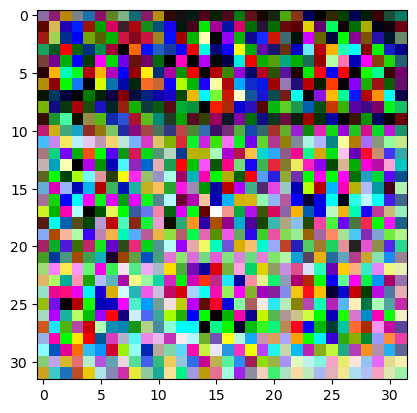

Epoch no. :  2
Discriminator loss after 0 steps = 0.5825114250183105
Generator loss after 0 steps = 0.46739962697029114
Discriminator loss after 200 steps = 0.5561099499464035
Generator loss after 200 steps = 0.42714163661003113
Discriminator loss after 400 steps = 0.5664995759725571
Generator loss after 400 steps = 0.42714935541152954
Discriminator loss after 600 steps = 0.5737916827201843
Generator loss after 600 steps = 0.42424002289772034
Discriminator loss after 800 steps = 0.5443162322044373
Generator loss after 800 steps = 0.41279715299606323


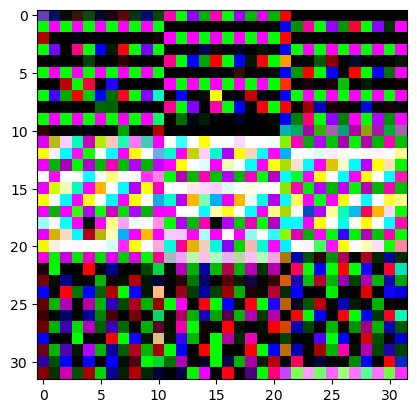

Epoch no. :  3
Discriminator loss after 0 steps = 0.5737943351268768
Generator loss after 0 steps = 0.5278403162956238
Discriminator loss after 200 steps = 0.5414209514856339
Generator loss after 200 steps = 0.39536193013191223
Discriminator loss after 400 steps = 0.5475253760814667
Generator loss after 400 steps = 0.39487239718437195
Discriminator loss after 600 steps = 0.526709720492363
Generator loss after 600 steps = 0.375990092754364
Discriminator loss after 800 steps = 0.5219889730215073
Generator loss after 800 steps = 0.39894407987594604


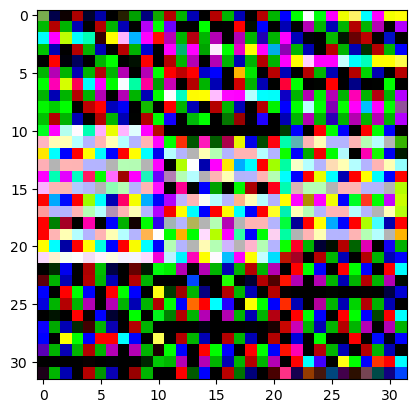

Epoch no. :  4
Discriminator loss after 0 steps = 0.6931734681129456
Generator loss after 0 steps = 0.626969039440155
Discriminator loss after 200 steps = 0.6372612714767456
Generator loss after 200 steps = 0.58180832862854
Discriminator loss after 400 steps = 0.6145879328250885
Generator loss after 400 steps = 0.5158377885818481
Discriminator loss after 600 steps = 0.5712270438671112
Generator loss after 600 steps = 0.39849501848220825
Discriminator loss after 800 steps = 0.5774325132369995
Generator loss after 800 steps = 0.5022107362747192


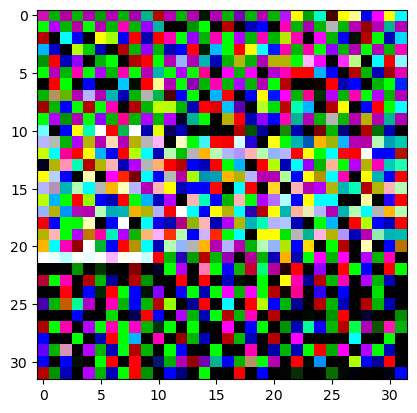

Epoch no. :  5
Discriminator loss after 0 steps = 0.6238653510808945
Generator loss after 0 steps = 0.4247084856033325
Discriminator loss after 200 steps = 0.5478495359420776
Generator loss after 200 steps = 0.4343007504940033
Discriminator loss after 400 steps = 0.6789621114730835
Generator loss after 400 steps = 0.4744565784931183
Discriminator loss after 600 steps = 0.5512074381113052
Generator loss after 600 steps = 0.4504201114177704
Discriminator loss after 800 steps = 0.5477867424488068
Generator loss after 800 steps = 0.5175607800483704


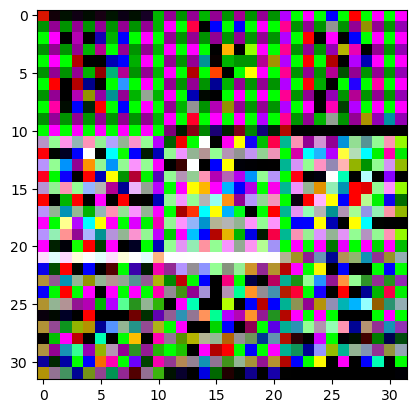

Epoch no. :  6
Discriminator loss after 0 steps = 0.6465749889612198
Generator loss after 0 steps = 0.4896315634250641
Discriminator loss after 200 steps = 0.5390473902225494
Generator loss after 200 steps = 0.5712076425552368
Discriminator loss after 400 steps = 0.521147683262825
Generator loss after 400 steps = 0.5547494888305664
Discriminator loss after 600 steps = 0.533882349729538
Generator loss after 600 steps = 0.41444313526153564
Discriminator loss after 800 steps = 0.5434025824069977
Generator loss after 800 steps = 0.48686012625694275


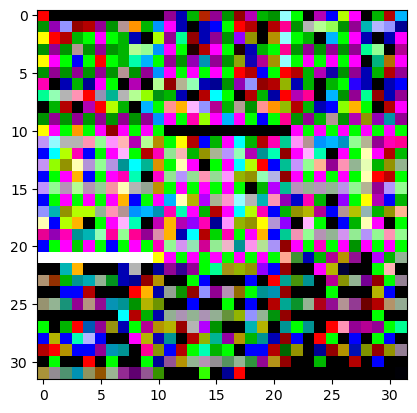

Epoch no. :  7
Discriminator loss after 0 steps = 0.536493793129921
Generator loss after 0 steps = 0.45762190222740173
Discriminator loss after 200 steps = 0.5923812389373779
Generator loss after 200 steps = 0.4341718256473541
Discriminator loss after 400 steps = 0.6087006032466888
Generator loss after 400 steps = 0.4410021901130676
Discriminator loss after 600 steps = 0.9857098609209061
Generator loss after 600 steps = 0.4073866307735443
Discriminator loss after 800 steps = 0.5539215058088303
Generator loss after 800 steps = 0.587050199508667


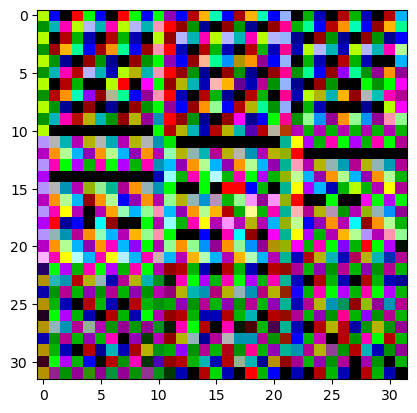

Epoch no. :  8
Discriminator loss after 0 steps = 0.5295730084180832
Generator loss after 0 steps = 0.6100755333900452
Discriminator loss after 200 steps = 0.5214193165302277
Generator loss after 200 steps = 0.5032587647438049
Discriminator loss after 400 steps = 0.514555424451828
Generator loss after 400 steps = 0.6068986654281616
Discriminator loss after 600 steps = 0.5405829548835754
Generator loss after 600 steps = 0.7102593779563904
Discriminator loss after 800 steps = 0.7768993526697159
Generator loss after 800 steps = 0.5192408561706543


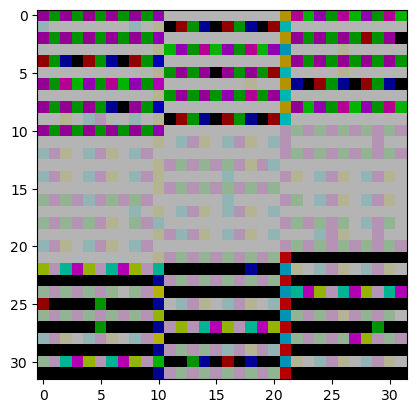

Epoch no. :  9
Discriminator loss after 0 steps = 0.7105920016765594
Generator loss after 0 steps = 0.4725664556026459
Discriminator loss after 200 steps = 0.5467534214258194
Generator loss after 200 steps = 0.6173739433288574
Discriminator loss after 400 steps = 0.7916975766420364
Generator loss after 400 steps = 0.5667139291763306
Discriminator loss after 600 steps = 0.6382390856742859
Generator loss after 600 steps = 0.4889546036720276
Discriminator loss after 800 steps = 0.5361136198043823
Generator loss after 800 steps = 0.7152605056762695


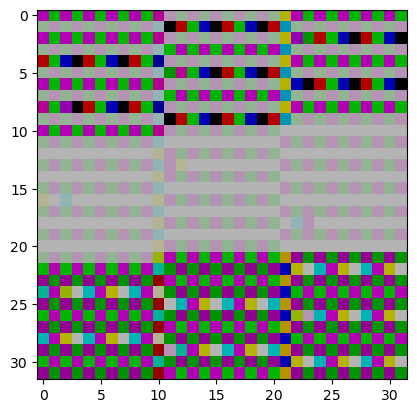

Epoch no. :  10
Discriminator loss after 0 steps = 0.5674676895141602
Generator loss after 0 steps = 0.7209434509277344
Discriminator loss after 200 steps = 0.5317879319190979
Generator loss after 200 steps = 0.719382107257843
Discriminator loss after 400 steps = 0.5319074243307114
Generator loss after 400 steps = 0.7181674242019653
Discriminator loss after 600 steps = 0.5117279589176178
Generator loss after 600 steps = 0.6958948969841003
Discriminator loss after 800 steps = 0.5294415950775146
Generator loss after 800 steps = 0.715997576713562


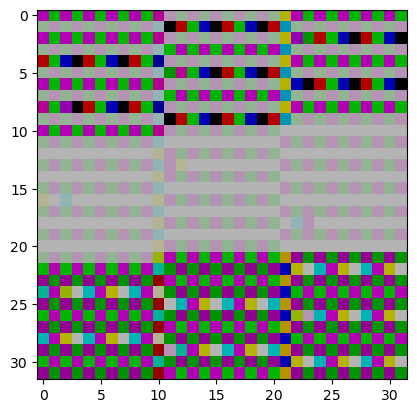

Epoch no. :  11
Discriminator loss after 0 steps = 0.7468955814838409
Generator loss after 0 steps = 0.4599011242389679
Discriminator loss after 200 steps = 0.5223110914230347
Generator loss after 200 steps = 0.7184182405471802
Discriminator loss after 400 steps = 0.5120650231838226
Generator loss after 400 steps = 0.7172070741653442
Discriminator loss after 600 steps = 0.5142166614532471
Generator loss after 600 steps = 0.7164604067802429
Discriminator loss after 800 steps = 0.5254239588975906
Generator loss after 800 steps = 0.698369562625885


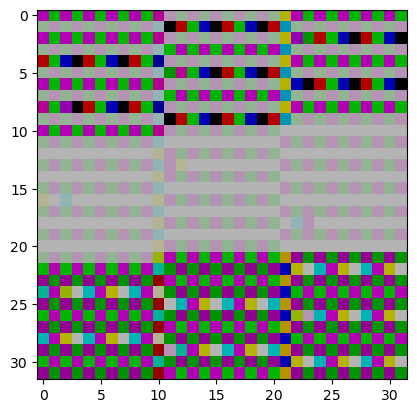

Epoch no. :  12
Discriminator loss after 0 steps = 0.4986812472343445
Generator loss after 0 steps = 0.7146217226982117
Discriminator loss after 200 steps = 0.5002886801958084
Generator loss after 200 steps = 0.6552407741546631
Discriminator loss after 400 steps = 0.4987689256668091
Generator loss after 400 steps = 0.7123854160308838
Discriminator loss after 600 steps = 0.5073673129081726
Generator loss after 600 steps = 0.7119696140289307
Discriminator loss after 800 steps = 0.5025535672903061
Generator loss after 800 steps = 0.7151443958282471


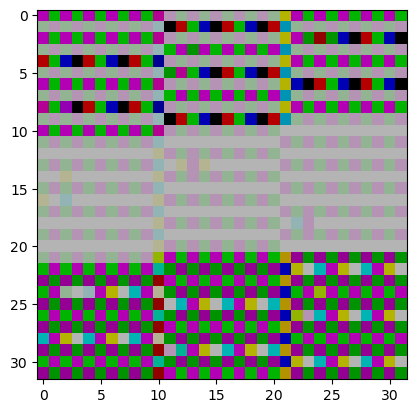

Epoch no. :  13
Discriminator loss after 0 steps = 0.49426524341106415
Generator loss after 0 steps = 0.7143951058387756
Discriminator loss after 200 steps = 0.5066838413476944
Generator loss after 200 steps = 0.7156001329421997
Discriminator loss after 400 steps = 0.4883269667625427
Generator loss after 400 steps = 0.7150993347167969
Discriminator loss after 600 steps = 0.7054029256105423
Generator loss after 600 steps = 0.6898716688156128
Discriminator loss after 800 steps = 0.5054773539304733
Generator loss after 800 steps = 0.6824030876159668


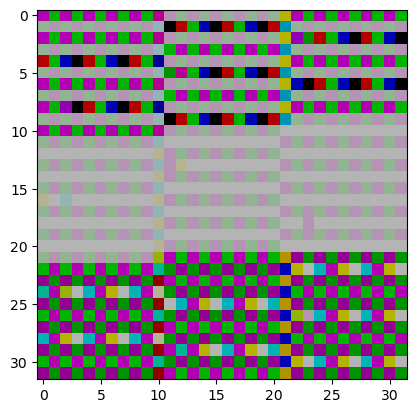

Epoch no. :  14
Discriminator loss after 0 steps = 0.4908796101808548
Generator loss after 0 steps = 0.7163801193237305
Discriminator loss after 200 steps = 0.49558305740356445
Generator loss after 200 steps = 0.7150471210479736
Discriminator loss after 400 steps = 0.478114515542984
Generator loss after 400 steps = 0.7149386405944824
Discriminator loss after 600 steps = 0.4967685341835022
Generator loss after 600 steps = 0.7151229977607727
Discriminator loss after 800 steps = 0.4857575446367264
Generator loss after 800 steps = 0.673782467842102


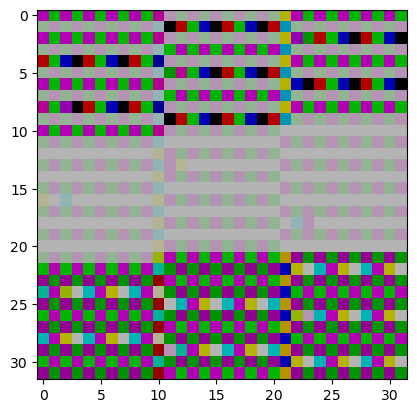

Epoch no. :  15
Discriminator loss after 0 steps = 0.48837073147296906
Generator loss after 0 steps = 0.7094845175743103
Discriminator loss after 200 steps = 0.8700023740530014
Generator loss after 200 steps = 0.7094525098800659
Discriminator loss after 400 steps = 0.4874318987131119
Generator loss after 400 steps = 0.7172040343284607
Discriminator loss after 600 steps = 0.5018624365329742
Generator loss after 600 steps = 0.716558039188385
Discriminator loss after 800 steps = 0.5614070147275925
Generator loss after 800 steps = 0.7153012752532959


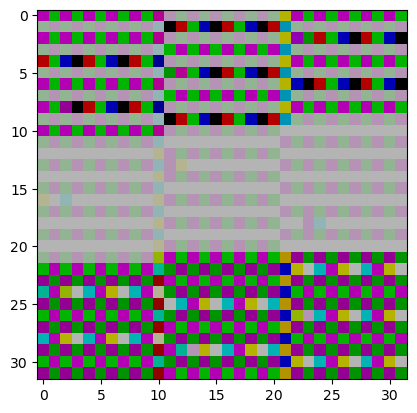

Epoch no. :  16
Discriminator loss after 0 steps = 0.5452937483787537
Generator loss after 0 steps = 0.7137615084648132
Discriminator loss after 200 steps = 0.5199296474456787
Generator loss after 200 steps = 0.7122406363487244
Discriminator loss after 400 steps = 0.5039071589708328
Generator loss after 400 steps = 0.7107445597648621
Discriminator loss after 600 steps = 0.5056528449058533
Generator loss after 600 steps = 0.6626936197280884
Discriminator loss after 800 steps = 0.500090166926384
Generator loss after 800 steps = 0.709937572479248


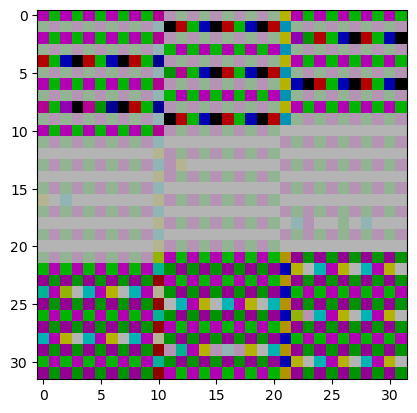

Epoch no. :  17
Discriminator loss after 0 steps = 0.48772385716438293
Generator loss after 0 steps = 0.7089729309082031
Discriminator loss after 200 steps = 0.5024540424346924
Generator loss after 200 steps = 0.7088704705238342
Discriminator loss after 400 steps = 0.4915691167116165
Generator loss after 400 steps = 0.6870474219322205
Discriminator loss after 600 steps = 0.5287203341722488
Generator loss after 600 steps = 0.7092539668083191
Discriminator loss after 800 steps = 0.4952595680952072
Generator loss after 800 steps = 0.6613985300064087


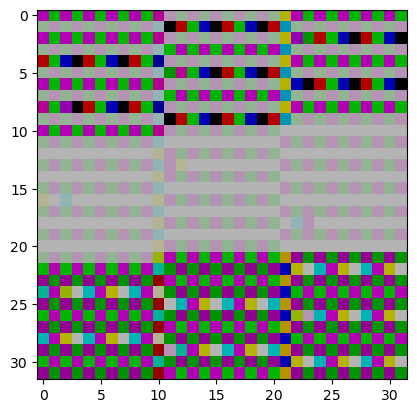

Epoch no. :  18
Discriminator loss after 0 steps = 0.5293553322553635
Generator loss after 0 steps = 0.6922280192375183
Discriminator loss after 200 steps = 0.5065136849880219
Generator loss after 200 steps = 0.6984530687332153
Discriminator loss after 400 steps = 0.4892650544643402
Generator loss after 400 steps = 0.7071770429611206
Discriminator loss after 600 steps = 0.48667676746845245
Generator loss after 600 steps = 0.7083786129951477
Discriminator loss after 800 steps = 0.49799706041812897
Generator loss after 800 steps = 0.7068400382995605


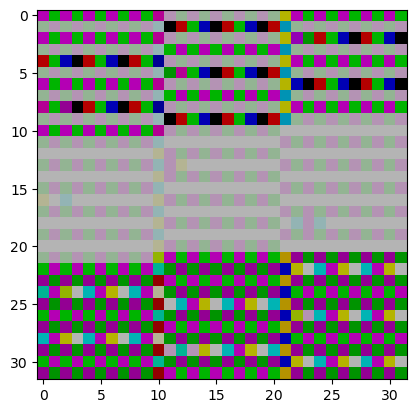

Epoch no. :  19
Discriminator loss after 0 steps = 0.48584379255771637
Generator loss after 0 steps = 0.7126040458679199
Discriminator loss after 200 steps = 0.49029526114463806
Generator loss after 200 steps = 0.6863268613815308
Discriminator loss after 400 steps = 0.4763946235179901
Generator loss after 400 steps = 0.71197110414505
Discriminator loss after 600 steps = 0.48850278556346893
Generator loss after 600 steps = 0.7118499875068665
Discriminator loss after 800 steps = 0.4938928633928299
Generator loss after 800 steps = 0.7124848961830139


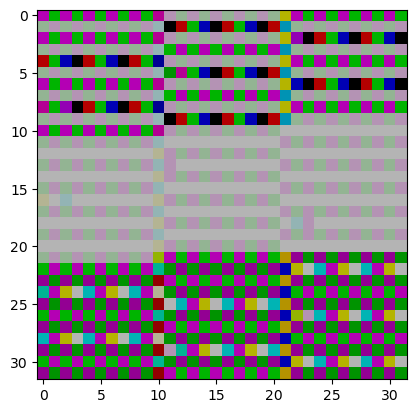

Epoch no. :  20
Discriminator loss after 0 steps = 0.48230643570423126
Generator loss after 0 steps = 0.7091901302337646
Discriminator loss after 200 steps = 0.5042847394943237
Generator loss after 200 steps = 0.7074103951454163
Discriminator loss after 400 steps = 0.5216208547353745
Generator loss after 400 steps = 0.7174745798110962
Discriminator loss after 600 steps = 0.5053668469190598
Generator loss after 600 steps = 0.7163955569267273
Discriminator loss after 800 steps = 0.4965716451406479
Generator loss after 800 steps = 0.7151919603347778


In [ ]:
g_lr = 2e-4
for g_lr in np.arange(2e-4, 3e-4, 1e-4):
    for d_lr in np.arange(5e-4, 6e-4, 1e-4):
        for k in np.arange(3,4, 1):
            disc = Discriminator().to(device)
            gen = Generator().to(device)
            l_disc, l_gen, img = train(20, data_dir=data_dir,data_dir_val=data_dir_val, device=device, batch_size=50, disc_lr=d_lr, gen_lr=g_lr, k=k)
            loss_disc.append(l_disc)
            loss_gen.append(l_gen)
            images.append(img)

In [ ]:
for i in range(len(loss_gen)):
    plt.plot(loss_disc[i])
    plt.plot(loss_gen[i])
    plt.legend(["Discriminator loss", "Generator loss"])
    plt.show()
    
    # plt., loss_d[0]


In [ ]:
with torch.no_grad():
    gen_img = gen(torch.randn(10, dim_z, 1, 1, device=device))
    print(gen_img.shape)
    plt.imshow(gen_img[1].reshape(32, 32, 3).cpu().detach().numpy())
    print(disc(gen_img).flatten())

In [ ]:
loss_fn = torch.nn.BCELoss()

train_dataset = TrainDataset(data_dir)
train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0)
batch_size = 50
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=train_sampler,
)
if train == False:
    val_dataset = ValDataset(data_dir_val)
    val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        sampler=val_sampler,
    )

optimG = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.0))
optimD = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.0))

# for j, mini_batch in enumerate(train_loader):
mini_batch = next(iter(train_loader))
optimG.zero_grad()

for _ in range(3):
    optimD.zero_grad()

    # train disc first
    x_real = mini_batch["img"].to(device)
    x_real = x_real.view(batch_size, num_in_channels, 32, 32)
    labels = torch.full(
        (batch_size,), 1.0, dtype=torch.float32, device=device
    )
    # out_disc_r = disc(x_real).flatten().sigmoid()
    out_disc_r = disc(x_real).flatten()

    # print(out_disc_r)
    loss_disc_r = loss_fn(out_disc_r, labels)
    loss_disc_r.backward()

    x_fake = gen(torch.randn(batch_size, dim_z, 1, 1))
    labels = torch.full(
        (batch_size,), 0.0, dtype=torch.float32, device=device
    )
    # out_disc_f = disc(x_fake).flatten().sigmoid()
    out_disc_f = disc(x_fake).flatten()
    loss_disc_f = loss_fn(out_disc_f, labels)
    loss_disc_f.backward()

    loss_disc = (
        loss_disc_f.mean().item() + loss_disc_r.mean().item()
    ) / 2.0
    if _ != 2:
        optimD.step()

# train gen
x_gen = gen(torch.randn(batch_size, dim_z, 1, 1))
# out = disc(x_gen).flatten().sigmoid()
out = disc(x_gen).flatten()
labels = torch.full(
    (batch_size,), 1.0, dtype=torch.float32, device=device
)
loss_gen = loss_fn(out, labels)
loss_gen.backward()


# optimG.step()

In [ ]:
def train(gpu, args):
    rank = args.nr * args.gpus + gpu
    torch.distributed.init_process_group(
        backend="nccl",
        init_method="env://",
        world_size=args.world_size,
        rank=rank,
    )

    torch.manual_seed(0)
    torch.cuda.set_device(gpu)
    model = test_net().cuda(gpu)

    batch_size = 100

    loss_fn = torch.nn.BCELoss()
    optim = torch.optim.Adam(model.parameters(), lr=1e4)
    model = nn.parallel.DistributedDataParallel(model, device_ids=[gpu])
    # model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
    # model = DDP(model)

    total_steps = len(train_loader)
    for epoch in range(args.epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)

            if (i + 1) % 100 == 0 and gpu == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch + 1, args.epochs, i + 1, total_steps, loss.item()
                    )
                )